In [1]:
import copy
import operator
import sre_parse
import sre_constants
from functools import reduce
from random import Random
from importlib import reload
from dataclasses import asdict
from typing import Tuple
from collections import defaultdict, Counter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import Path as MarkerPath
from matplotlib.transforms import Affine2D
from matplotlib.collections import PatchCollection
import seaborn as sns
from ipywidgets import Accordion, HTML, VBox, HBox, Output, Button, Layout, Dropdown, Tab, Widget, GridBox, Text
from ipywidgets import Label, GridspecLayout
from tqdm import tqdm

In [3]:
import constants
reload(constants)
import solver
reload(solver)

<module 'solver' from '/data/Development/regex_crossword/solver.py'>

In [4]:
plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 400)
pd.set_option('display.max_colwidth', 400)

In [5]:
strings = solver.build_strings()

In [6]:
with tqdm(strings, desc='init solutions') as progress:
    solution_sets = [solver.SparseSolutionSet.for_string(s) for s in progress]

init solutions: 100%|██████████| 39/39 [00:01<00:00, 34.99it/s]


In [24]:
original_solution_set = reduce(lambda a, b: a.intersection(b), solution_sets)

In [25]:
solution_set = original_solution_set
with tqdm(range(10), desc='filter') as progress:
    for _ in progress:
        solution_set = solution_set.filter_cells_using_other_unions()
        solution_set = solution_set.apply_references()
        solution_set = solution_set.push_reference_constraints()

filter: 100%|██████████| 10/10 [00:00<00:00, 19.14it/s]


In [9]:
# solution_set.common_intersection().size()

In [10]:
# solutions = list(solution_set.iter_solutions())
# len(solutions)

In [26]:
cell_constraints = pd.Series([len(cc.constraint_dimensions) for cc in solution_set.cells.values()])
cell_constraints.value_counts().sort_index()

1     120
2       4
3       1
5       1
16      1
dtype: int64

In [27]:
reduce(operator.mul, cell_constraints)

3840

In [28]:
lit_constraints = pd.Series({ix: frozenset(con.lit_component for con,comb in c.constraint_dimensions)
 for ix,c in solution_set.cells.items()})

In [29]:
lit_constraints.map(len).value_counts()

1    124
2      2
4      1
dtype: int64

In [30]:
np.prod(lit_constraints.map(len))

16

(-4.0, 15.0)

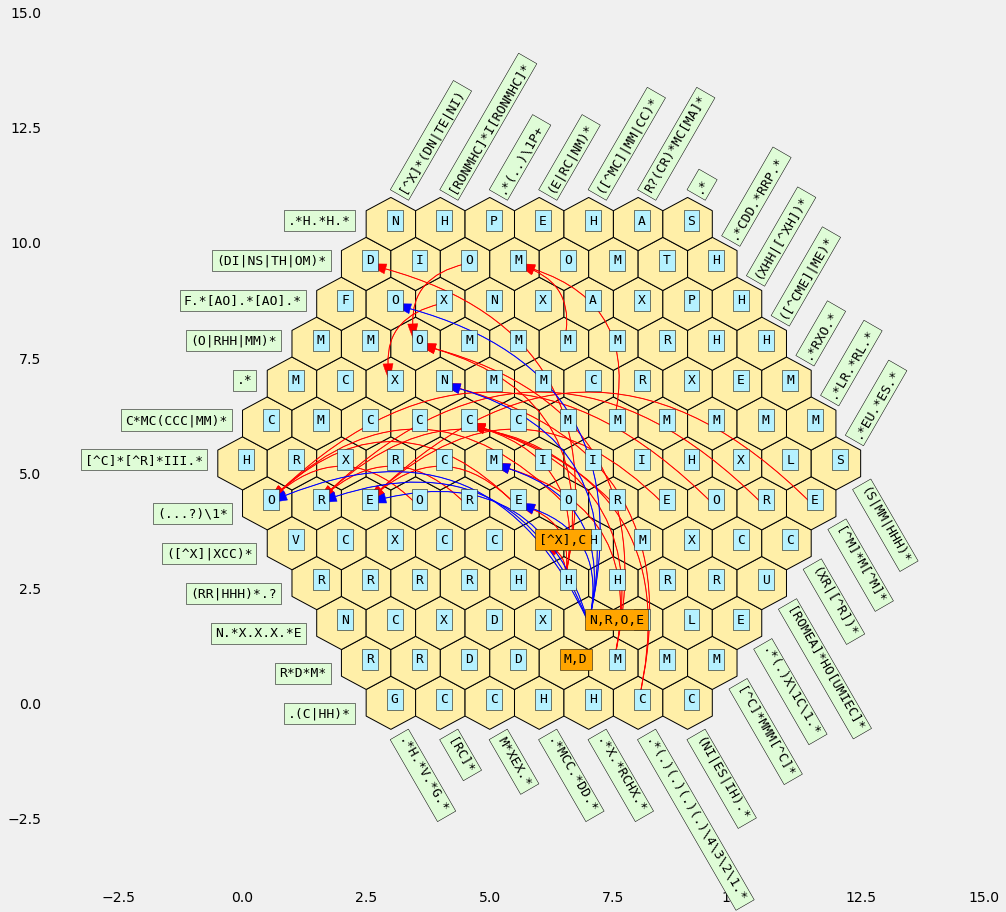

In [34]:
def merge_constraints(ix):
    lit_con, = lit_constraints[ix]
    cds = solution_set.cells[ix]
    refs = frozenset(ref for con,comb in cds
                         for ref in con.ref_component.indices)
    return lit_con if not refs else solver.CompoundConstraint(lit_con, solver.RefConstraint(refs))

drawer = solver.draw_puzzle(fig_size=15, solution=
                   solver.Solution({ix:merge_constraints(ix)
                                    for ix,ls in lit_constraints.items() if len(ls) == 1}))
for ix, ls in lit_constraints.items():
    if len(ls) == 1:
        continue
    x, y = drawer.position(*ix)
    drawer.text(x, y, ','.join(l.label() for l in ls), background_color='orange')
    cds = solution_set.cells[ix]
    if cds.has_references:
        for ref in cds.references():
            drawer.draw_arrow((x,y), drawer.position(*ref), color='b')
    
drawer.ax.grid(False)
plt.xlim(-4, 15)
plt.ylim(-4, 15)

In [22]:
list(solution_set.cells[7, 4])

[(<LiteralConstraint C>, <solver.DimensionCombination at 0x7f9952645a30>),
 (<CompoundConstraint C : 8,3>,
  <solver.DimensionCombination at 0x7f9952655850>)]

In [18]:
list(solution_set.cells[8, 3])

[(<LiteralConstraint N>, <solver.DimensionCombination at 0x7f99524b36d0>)]

In [19]:
list(solution_set.cells[7, 4].apply_references(solution_set.cells))

[(<LiteralConstraint C>, <solver.DimensionCombination at 0x7f9952645a30>)]

In [20]:
for ix, cell in sorted(solution_set.cells.items()):
    if not cell.has_references:
        continue
    print(ix, cell.constraints(), cell.references())

(0, 5) [<CompoundConstraint C : 7,4>, <LiteralConstraint C>, <CompoundConstraint H : 7,4>, <LiteralConstraint H>] {(7, 4)}
(1, 5) [<CompoundConstraint D : 6,5>, <CompoundConstraint D : 8,3>, <LiteralConstraint D>, <CompoundConstraint M : 6,5>, <CompoundConstraint M : 8,3>, <LiteralConstraint M>] {(8, 3), (6, 5)}
(2, 5) [<CompoundConstraint [^MEC] : 5,5>, <CompoundConstraint [^MEC] : 7,4>, <CompoundConstraint [^MEC] : 9,2>, <LiteralConstraint [^MEC]>, <CompoundConstraint E : 5,5>, <CompoundConstraint E : 7,4>, <CompoundConstraint E : 9,2>, <LiteralConstraint E>] {(7, 4), (5, 5), (9, 2)}
(3, 5) [<CompoundConstraint H : 4,5>, <CompoundConstraint H : 6,5>, <CompoundConstraint H : 8,3>, <CompoundConstraint H : 10,1>, <LiteralConstraint H>] {(4, 5), (10, 1), (6, 5), (8, 3)}
(4, 5) [<LiteralConstraint [^X]>, <CompoundConstraint [^X] : 5,5>, <CompoundConstraint [^X] : 7,4>, <CompoundConstraint [^X] : 9,2>, <CompoundConstraint [^X] : 11,0>, <LiteralConstraint C>, <CompoundConstraint C : 5,5>, <

In [21]:
raise 'hell'

TypeError: exceptions must derive from BaseException

In [ ]:
push_solution = filter_solution_many.push_reference_constraints()

In [ ]:
cell_constraints = pd.Series([len(cc.constraint_dimensions) for cc in push_solution.cells.values()])
cell_constraints.value_counts().sort_index()

In [ ]:
reduce(operator.mul, cell_constraints)

In [ ]:
[[[str(con), comb.size()] for con,comb in cell]
 for cell in push_solution.cells.values() if len(cell) > 1]

In [ ]:
comb = reduce(lambda a, b: a.intersection(b),
                      (c.union_constraint() for c in push_solution.cells.values()))
comb.size()

In [ ]:
list(filter(None, [0, 1, 2, None, 3, False, True]))

In [ ]:
pd.Series({dim :sol.size(dim) for dim, sol in comb}).sort_values(ascending=False)

In [ ]:
constrained_cell_solution = solver.Solution({ix:c.constraint_dimensions[0][0]
 for ix,c in filter_solution_many.cells.items() if len(c.constraint_dimensions) == 1})
constrained_cell_solution

In [ ]:
solver.draw_puzzle(fig_size=15, solution=constrained_cell_solution)

In [ ]:
cds = min(s.cells.values(), key=lambda cc: len(cc.constraint_dimensions)).constraint_dimensions
cds

In [ ]:
pd.Series(cds).map(lambda x: x[0])

In [ ]:
df = pd.DataFrame([{'cell': ix,
 'constraint': cc.constraint_dimensions[0][0],
  **{
      d:s for d,s in cc.constraint_dimensions[0][1].dimensions.items()
  }
 }
 for ix,cc in s.cells.items() if len(cc.constraint_dimensions) == 1]
).set_index(['cell', 'constraint']).sort_index().T.sort_index()

df

In [ ]:
dim_sizes = pd.concat([col.apply(lambda x: x.size(dim)) for dim,col in df.iterrows()], axis=1).T
dim_sizes

In [ ]:
dim_frac = dim_sizes.div(pd.Series(df.index, df.index).map(lambda x: x.size), axis=0).round(1)
dim_frac

In [ ]:
f = plt.figure(figsize=(8, 15))
ax = f.add_subplot(111)
sns.heatmap(dim_frac, linewidth=0.05, ax=ax)

In [ ]:
single_constraint_indexes = sorted(dim_frac.columns.get_level_values('cell'))
single_constraint_indexes

In [ ]:
acc = None
for ix in single_constraint_indexes:
    cds = s.cells[ix].constraint_dimensions
    assert len(cds) == 1
    comb = cds[0][1]
    if acc is None:
        acc = comb
    else:
        acc = comb.intersection(acc)

In [ ]:
single_constraint_sizes = pd.DataFrame([{'dim': dim,
  'total_size': dim.size,
  'sol_size': ds.size(dim)}
 for dim,ds in acc.dimensions.items()]
).set_index('dim').sort_index()

single_constraint_sizes['frac'] = (single_constraint_sizes['sol_size'] / single_constraint_sizes['total_size']).round(3)
single_constraint_sizes

In [ ]:
single_constraint_sizes['frac'].plot.hist()

In [ ]:
single_constraint_sizes['frac'].describe()

In [ ]:
single_constraint_sizes.sort_values('frac').head(10)

In [ ]:
df = pd.DataFrame([{d:s for d,s in x.dimensions.items()}
                   for _,x in cds],
                  index=[x for x,_ in cds])
df

In [ ]:
df.sort_index()

In [ ]:
df.T.sort_index()

In [ ]:
ds_counts = df.apply(Counter).sort_index()
ds_counts

In [ ]:
ds_counts_not_all = ds_counts[~ds_counts.map(lambda x: x.keys() == {solver.dimension_all})]
ds_counts_not_all

In [ ]:
x = df[ds_counts_not_all.index].copy().sort_index()
x

In [ ]:
y = pd.concat([col.map(lambda ds: ds.size(dim)) for dim, col in x.T.iterrows()], axis=1)
y['combs'] = np.prod(y, axis=1)
y

In [ ]:
dim = ds_counts_not_all.index[0]
dim

In [ ]:
df[dim].sort_index()

In [ ]:
df[dim].sort_index().map(lambda x: sorted(x.indexes))

In [ ]:
pd.Series(list(reduce(lambda a,b: a | b, df[dim].sort_index().map(lambda x: x.indexes))))

In [ ]:
pd.Series(reduce(lambda a,b : a + b,
                 df[dim].sort_index().map(lambda x: list(x.indexes)))
).value_counts()

In [ ]:
lit_cons = defaultdict(list)
for con in df.index:
    lit_cons[con.lit_component].append(con)
lit_cons

In [ ]:
list(s.cells.values())[0].constraint_dimensions

In [ ]:
lit_cell_constraints = pd.Series([len({con.lit_component for con, comb in cc.constraint_dimensions})
                              for cc in s.cells.values()])
lit_cell_constraints.value_counts().sort_index()

In [ ]:
reduce(operator.mul, lit_cell_constraints)

In [ ]:
reduce(operator.mul, cell_constraints) / reduce(operator.mul, lit_cell_constraints)

In [ ]:
cds = list(s.cells.values())[lit_cell_constraints.idxmax()].constraint_dimensions
cds

In [ ]:
df = pd.DataFrame([{d:s for d,s in x.dimensions.items()}
                   for _,x in cds],
                  index=[x for x,_ in cds]).sort_index()
df

In [ ]:
df.T

In [ ]:
ds_counts = df.apply(Counter).sort_index()
ds_counts

In [ ]:
ds_counts_not_all = ds_counts[~ds_counts.map(lambda x: x.keys() == {solver.dimension_all})]
ds_counts_not_all

In [ ]:
x = df[ds_counts_not_all.index].copy().sort_index()
x['combs'] = np.prod(x.applymap(lambda x: len(x.indexes)), axis=1)
x

In [ ]:
cell_refs = set()
for ix,ccs in s.cells.items():
    for con, comb in ccs.constraint_dimensions:
        for target_ix in con.ref_component.indices:
            cell_refs.add((ix, target_ix, con.lit_component))
cell_refs = pd.DataFrame(list(map(list, cell_refs)), columns=['source', 'target', 'source_con'])
cell_refs['target_cons'] = cell_refs['target'].map(
    lambda ix: frozenset(con for con,comb in s.cells[ix].constraint_dimensions))
print(len(cell_refs))
cell_refs.sample(10)

In [ ]:
x = (cell_refs
 [cell_refs['source'].isin(cell_refs['source'].drop_duplicates().sample(5, random_state=0xCAFE))]
 .groupby('source'))
for source, y in x:
    print(source)
    display(y.sort_values('target'))

In [ ]:
set(cell_refs['source']) & set(cell_refs['target'])

In [ ]:
cds = s.cells[(10, 4)].constraint_dimensions
cds

In [ ]:
df = pd.DataFrame([{d:s for d,s in x.dimensions.items()}
                   for _,x in cds],
                  index=[x for x,_ in cds])
df

In [ ]:
ds_counts = df.apply(Counter).sort_index()
ds_counts

In [ ]:
ds_counts_not_all = ds_counts[~ds_counts.map(lambda x: x.keys() == {solver.dimension_all})]
ds_counts_not_all

In [ ]:
x = df[ds_counts_not_all.index].copy().sort_index()
x

In [ ]:
y = pd.concat([col.map(lambda ds: ds.size(dim)) for dim, col in x.T.iterrows()], axis=1)
y['combs'] = np.prod(y, axis=1)
y

In [ ]:
drawer = solver.draw_puzzle(fig_size=15)
for i,(source, target) in cell_refs[['source', 'target']].drop_duplicates().iterrows():
    drawer.draw_arrow(drawer.position(*source), drawer.position(*target))